# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

Please make sure if you are running this notebook in the workspace that you have chosen GPU rather than CPU mode.

In [12]:
# Imports here
import torch
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import OrderedDict
from PIL import Image
import numpy as np
from workspace_utils import active_session
import json

In [13]:
# set computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [14]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [15]:
# Define transforms for the training, validation, and testing sets
train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(0.3),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])
                                       ])

test_transform = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])
                                       ])

# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=test_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

# Using the image datasets and the trainforms, define the dataloaders
batch_size = 100
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
validloader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [16]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

In [17]:
class Classifier(nn.Module):
    def __init__(self, input_size, output_size, hidden_layer_sizes):
        # make sure module is instantiated with at least one hidden layer
        assert hidden_layer_sizes, 'This module requires at least one hidden layer'
        super(Classifier, self).__init__()
        
        self.hidden_layers = nn.ModuleList([
            nn.Linear(input_size, hidden_layer_sizes[0]), 
            *[nn.Linear(i, o) for i, o in zip(hidden_layer_sizes[0:-1], hidden_layer_sizes[1:])]
            ])   
        
        self.dropout = nn.Dropout(0.2)     
        
        self.output_layer = nn.Linear(hidden_layer_sizes[-1], output_size)                    

    def forward(self, x):
        # unpack hidden layers
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
            x = self.dropout(x)
        # output layer
        x = F.log_softmax(self.output_layer(x), dim=1)
        return x

In [19]:
# Build and train your network
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

classifier = Classifier(1000, 102, [700, 400])
classifier.class_to_idx = cat_to_name

criterion = nn.NLLLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.0005)

model = model.to(device)
classifier = classifier.to(device)

In [18]:
def train_model(model, classifier, optimizer, criterion, epochs, min_validation_loss=float('inf'), save_filepath=''):
    classifier.train()
    
    train_loss_history = []
    valid_loss_history = []
    valid_acc_history = []

    for e in range(1, epochs+1):

        # Performance tracking variables
        train_loss = 0
        valid_loss = 0
        valid_correct = 0

        # Training pass
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            output = model(images)
            output = classifier(output)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            # Save batch loss
            train_loss += loss.to(device).item()

        # Valiation pass
        else:
            classifier.eval()
            with torch.no_grad():
                for images, labels in validloader:
                    images, labels = images.to(device), labels.to(device)

                    output = model(images)
                    output = classifier(output)
                    loss = criterion(output, labels)

                    # Save batch loss
                    valid_loss += loss.item()

                    # Save count of accurate predictions
                    ps = torch.exp(output)
                    _, preds = ps.topk(1, dim=1)
                    valid_correct += torch.sum(preds.view(-1,) == labels).item()
            classifier.train()

        # Use batch mean loss statistics to account for difference in data set sizes
        mean_train_loss = train_loss/(len(trainloader))
        mean_valid_loss = valid_loss/(len(validloader))

        # Calculate validation set accuracy
        valid_acc = 100*valid_correct / (len(validloader)*batch_size)

        # Save performance histories
        train_loss_history.append(mean_train_loss)
        valid_loss_history.append(mean_valid_loss)
        valid_acc_history.append(valid_acc)

        # Print performance statistics
        print(f'Epoch: {e} --  Mean Training Loss={mean_train_loss:.3f}.. ' 
              f'Mean Validation Loss = {mean_valid_loss:.3f}.. ' 
              f'Validation Accuracy = {valid_acc:.2f}%..')

        # Implement early stopping by saving classifier with minimum mean validation loss
        if save_filepath:
            if mean_valid_loss < min_validation_loss:
                min_validation_loss = mean_valid_loss
                print('Saving classifier...')
                save_checkpoint(classifier, save_filepath, input_output=(1000, 102), loss=min_validation_loss)
        
    histories = {'train_loss': train_loss_history, 
                 'valid_loss': valid_loss_history, 
                 'valid_accuracy': valid_acc_history}
        
    return histories

In [23]:
# Note: run the "Save the checkpoint" cell before running this cell
with active_session():
    epochs = 20
    history = train_model(model, classifier, optimizer, criterion,  
                          epochs, min_validation_loss=float('inf'), save_filepath='checkpoint.pth')

Epoch: 1 --  Mean Training Loss=0.800.. Mean Validation Loss = 0.509.. Validation Accuracy = 80.33%..
Saving classifier...
Epoch: 2 --  Mean Training Loss=0.681.. Mean Validation Loss = 0.417.. Validation Accuracy = 81.44%..
Saving classifier...
Epoch: 3 --  Mean Training Loss=0.642.. Mean Validation Loss = 0.364.. Validation Accuracy = 82.22%..
Saving classifier...
Epoch: 4 --  Mean Training Loss=0.610.. Mean Validation Loss = 0.386.. Validation Accuracy = 82.44%..
Epoch: 5 --  Mean Training Loss=0.579.. Mean Validation Loss = 0.329.. Validation Accuracy = 81.56%..
Saving classifier...
Epoch: 6 --  Mean Training Loss=0.539.. Mean Validation Loss = 0.315.. Validation Accuracy = 81.78%..
Saving classifier...
Epoch: 7 --  Mean Training Loss=0.541.. Mean Validation Loss = 0.359.. Validation Accuracy = 82.67%..
Epoch: 8 --  Mean Training Loss=0.489.. Mean Validation Loss = 0.354.. Validation Accuracy = 81.33%..
Epoch: 9 --  Mean Training Loss=0.482.. Mean Validation Loss = 0.338.. Validati

In [ ]:
plt.plot(history['train_loss'], label="train") 
plt.plot(history['valid_loss'], label="validation")
plt.legend()
plt.show

## Testing your network

In [22]:
# Do validation on the test set
correct = 0
with torch.no_grad():
    classifier.eval()
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)

        output = model(images)
        output = classifier(output)

        ps = torch.exp(output)
        _, preds = ps.topk(1, dim=1)
        correct += torch.sum(preds.view(-1,) == labels).item()
    classifier.train()
accuracy = 100*correct / (len(testloader)*batch_size)
print(f'Test set accuracy: {accuracy:.2f}%')

Test set accuracy: 81.44%


## Save the checkpoint

In [19]:
# Save the checkpoint
def save_checkpoint(classifier, filepath, input_output=(1000, 102), loss=float('inf')):
    checkpoint = {'input_size': input_output[0], # this comes from use of resnet
                  'output_size': input_output[1], # this comes from use of iris flower dataset
                  'cl_hidden_layers': [hidden.out_features for hidden in classifier.hidden_layers],
                  'state_dict': classifier.state_dict(),
                  'min_validation_loss': loss,
                  'class_to_idx': classifier.class_to_idx}
    torch.save(checkpoint, filepath)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [20]:
# Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
 
    # build classifier
    classifier = Classifier(checkpoint['input_size'],
                            checkpoint['output_size'],
                            checkpoint['cl_hidden_layers'])

    # load classifier state
    classifier.load_state_dict(checkpoint['state_dict'])

    # get class_to_idx attribute
    classifier.class_to_idx = checkpoint['class_to_idx']

    # load the validation loss from the time the model was saved
    min_validation_loss = checkpoint['min_validation_loss']
       
    return classifier, min_validation_loss

In [21]:
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

classifier, min_loss = load_checkpoint('checkpoint.pth')

criterion = nn.NLLLoss()
optimizer = optim.Adam(classifier.parameters())

model = model.to(device)
classifier = classifier.to(device)

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [23]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # resize image
    width, height = image.size
    if width > height:
        new_width = int(256 * float(width)/float(height))
        image = image.resize((new_width, 256))
    else:
        new_height = int(256 * float(height)/float(width))
        image = image.resize((256, new_height))

    # crop image
    width, height = image.size
    w1 = (width - 224)/2
    w2 = w1 + 224
    h1 = (height - 224)/2
    h2 = h1 + 224
    image = image.crop((w1, h1, w2, h2 ))

    # convert pixels to numpy array, scale pixel values, and transpose
    np_image = np.array(image)/255
    np_image = np.transpose(np_image, axes=[2, 0, 1])

    # normalize image values
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]    
    for i in range(3):
        for j in range(224):
            np_image[i][j]= (np_image[i][j] - means[i]) / stds[i]
        
    return np_image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [24]:
# This function is provided by Udacity
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

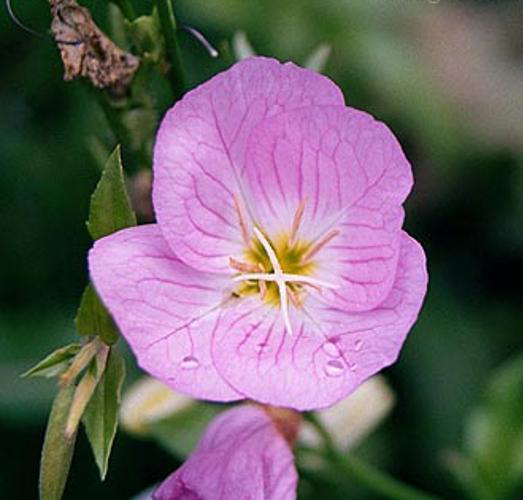

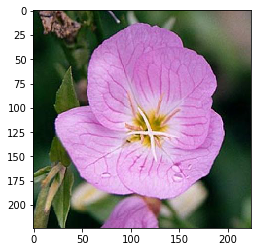

In [19]:
image_path = train_dir + '/1/image_06734.jpg'
image = Image.open(image_path)
display(image)
np_image = process_image(image)
display(imshow(np_image))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

In [25]:
def predict(image_path, model, classifier, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    # TODO: Implement the code to predict the class from an image file
    
    image = Image.open(image_path)
    np_image = process_image(image)
    tensor_image = torch.tensor(np_image, dtype=torch.float32, device=device)
    tensor_image = torch.unsqueeze(tensor_image, 0)
    with torch.no_grad():
        classifier.eval()
        output = model(tensor_image)
        output = classifier(output)
        classifier.train()
    
    ps = torch.exp(output)
    probabilities, classes = ps.topk(topk, dim=1)
   
    probabilities = list(probabilities.data.cpu().numpy().squeeze())
    classes = list(classes.data.cpu().numpy().squeeze())
    
    class_names = [classifier.class_to_idx[str(cat)] for cat in classes]
    
    return probabilities, class_names


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

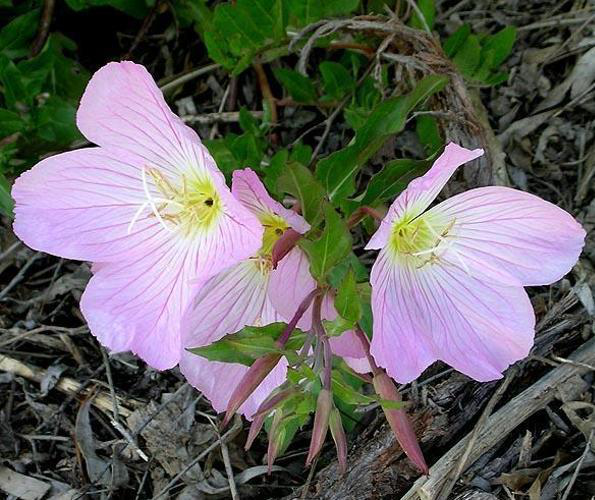

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


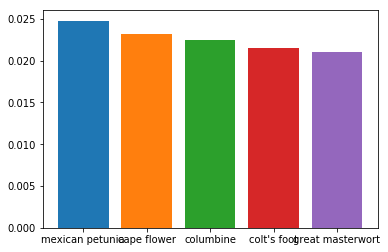

In [28]:
# TODO: Display an image along with the top 5 classes
image_path = train_dir + '/1/image_06737.jpg'
image = Image.open(image_path)
display(image)

probabilities, class_names = predict(image_path, model, classifier, topk=5)
for i in range(len(probabilities)):
    plt.bar([i], probabilities[i])
class_names.insert(0,'')
plt.axes().set_xticklabels(class_names)
plt.show()